# OpenQuake results for a specific path of the network

This IPython notebook allows the user to analyse the results obtained from a scenario damage analysis on a specific path of the transportation network. 
The notebook uses as input the following .xml files:
   - exposure model
   - fragility functions 
   - repair model.
   - ground motion fields
   
As an output, it is possible to calculate:
   - repair time
   - disruption time.


In [1]:
import utils
import utilsPlot
%matplotlib inline

from time import gmtime, strftime

/opt/openquake/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Importing exposure and fragility models

Specify the path of the exposure and fragility models (.xlm format):

In [43]:
exposure_file = '/media/sf_Shared_Folder/Paper_Scenarios/2016-09-Revision/exposure_modelSpain.xml'
exposure_model = utils.read_exposure_model(exposure_file)

In [24]:
fragility_file = '/media/sf_Shared_Folder/Paper_Scenarios/2016-09-Revision/ff_bridges_4FF.xml'
fragility_model = utils.read_fragility_model(fragility_file)
#utilsPlot.plot_ff(fragility_model)

## Importing ground motion fields .xml file

Option A: If you only have one file for the ground motion fields (.xml format)

Option B: If you want to combine the gmfs of more than one file using specific weights

In [58]:
#Option A
#gmfs_file='/media/sf_Shared_Folder/Paper_Scenarios/2016-09-Revision/Sensitivity_analysis/gmpesLx/out/gmf-rlz-000_134.xml'
#gmfs_file='/media/sf_Shared_Folder/Paper_Scenarios/2016-09-Revision/ScenarioD/out/gmf-rlz-000_90.xml'

#gmfs = utils.read_gmfs_file(gmfs_file, exposure_model)


#Option B
#Atkinson and Boore
gmfs_file1='/media/sf_Shared_Folder/Paper_Scenarios/2016-09-Revision/scenarioA/out/gmf-rlz-000_96.xml'
weight_1 = float(0.7)
#Akkar and Bommer
gmfs_file2 = '/media/sf_Shared_Folder/Paper_Scenarios/2016-09-Revision/scenarioA/out/gmf-rlz-000_92.xml'
weight_2 = float(0.3)

gmfs = utils.combine_gmfs(gmfs_file1, gmfs_file2, exposure_model, weight_1, weight_2)


To plot and/or save the gmf, choose the measure you want to consider (it can be set to median, mean or percentile).

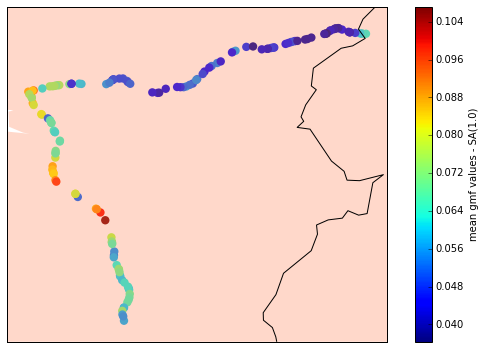

In [59]:
measure = 'mean'
percentileValue = 50
save_gmf = True
logScale = False

utilsPlot.plot_gmf_path(gmfs, measure, percentileValue, logScale, save_gmf)

## Damage levels calculation - considering damage correlation

In [5]:
damage_levels = utils.calculate_damage(gmfs['gmv'], exposure_model, fragility_model)

Define the repair time curves for each fragility function in the exposure model

In [6]:
#Repair curves Shinozuka
timeShinozuka = []

timeND = [0,0]
timeS = [10,150]
timeM = [20,200]
timeE = [60,250]
timeC = [75,300]

timeND2 = [0,0]
timeS2 = [0,0]
timeM2 = [0,0]
timeE2 = [60,250]
timeC2 = [5,15]

timeShinozuka.append([timeND,timeS,timeM,timeE,timeC])
timeShinozuka.append([timeND,timeS,timeM,timeE,timeC])
timeShinozuka.append([timeND,timeS,timeM,timeE,timeC])
timeShinozuka.append([timeND2,timeS2,timeM2,timeE2,timeC2])

Define the correlation coefficient for damage and for repair time

Define the number of samples

In [7]:
damCorr = 1
RTCorr = 1
num_dam_samples = 100

DamState_total, RT_total, DT_total = utils.apply_dam_RT_corr(damCorr, RTCorr, num_dam_samples, 
                damage_levels, gmfs, fragility_model, exposure_model, timeShinozuka)

Task started at 2016-12-09 18:23:05
Task ended at 2016-12-09 18:24:08


Calculate collapse and disruption probability

In [ ]:
import numpy as np
probColl = []
DamState_array = np.array(DamState_total)
for i in xrange(len(DamState_array[0])):
    sample_coll = np.where(DamState_array[:,i] == 5)
    if len(sample_coll[0]) != 0:
        probColl.append(1)
    else:
        probColl.append(0)
        
print "Collapse Probability = %f" %(float(sum(probColl))/len(probColl))


probDisr = []
for i in xrange(len(DamState_array[0])):
    sample_coll = np.where(DamState_array[:,i]==5)
    saples_exte = np.where(DamState_array[:,i]==4)
    if len(sample_coll[0]) or len(saples_exte[0]) != 0:
        probDisr.append(1)
    else:
        probDisr.append(0)

print "Disruption Probability = %f" %(float(sum(probDisr))/len(probDisr))

Calculate repair and disruption time. 

Option 1: sum of the repair times for all bridges (consider only one construction team)

Option 2: maximum repair time among all bridges (consider unlimited number of construction teams)

In [ ]:
#Option 1
RT_final = np.sum(np.array(RT_total),axis=0)
DT_final = np.sum(np.array(DT_total),axis=0)

#Option 2
RT_final = np.max(np.array(RT_total),axis=0)
DT_final = np.max(np.array(DT_total),axis=0)

utils.print_stats(RT_final)
utils.print_stats(DT_final)